## Import

In [ ]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, AveragePooling1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras import activations
from sklearn.metrics import confusion_matrix
from utils.df_utils import df_wrapper
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [ ]:
AMOUNT_OF_SENSORS = 2
VALIDATION_TESTSET = "004"

## Datapreparation

### Train

In [ ]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test

In [ ]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Visualisation

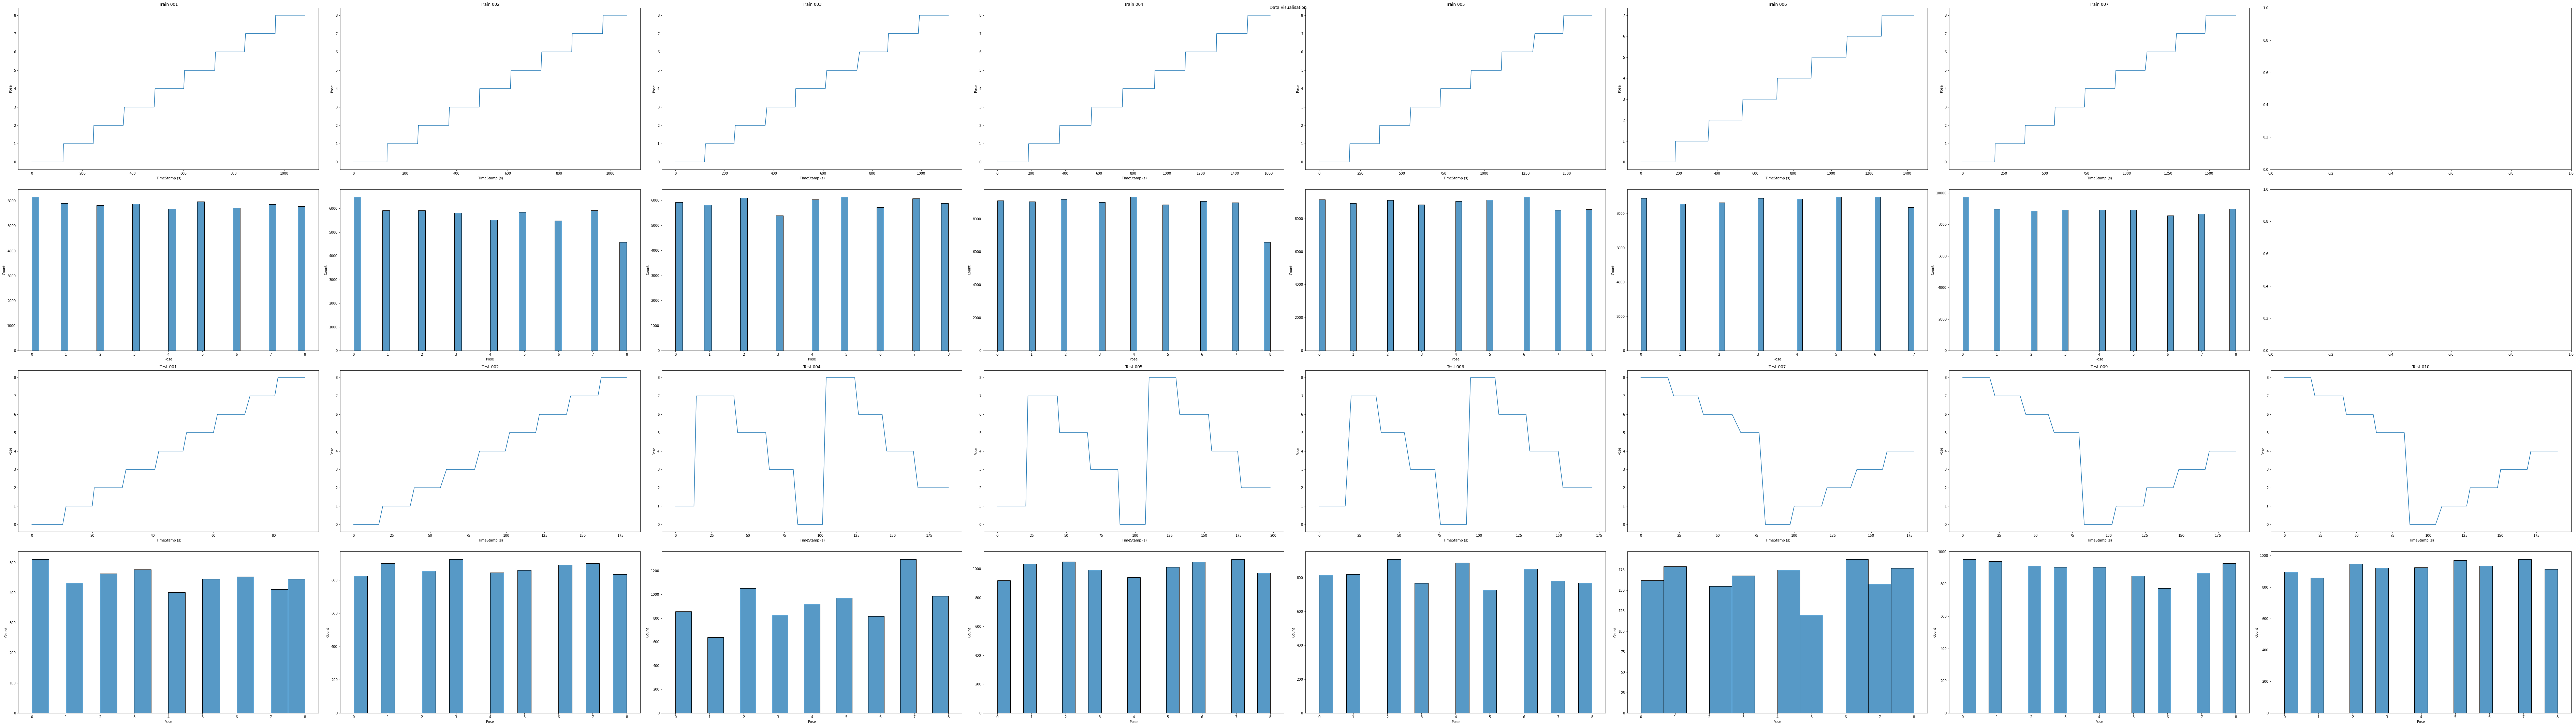

In [ ]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4, max(len(training_files), len(testing_files)), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i, elem in enumerate(x_train_arr):
    sns.lineplot(ax=axes[0, i], data=elem.df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=elem.df["Pose"])
    cols.append(f'Train 00{i+1}')    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}') 
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [ ]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

# Change shape for CNN
x_train_numpy = x_train_numpy.reshape(x_train_numpy.shape[0],x_train_numpy.shape[1], 1)
x_test_numpy = x_test_numpy.reshape(x_test_numpy.shape[0],x_test_numpy.shape[1], 1)

## Hyperparams

In [ ]:
EPOCH = 25
BATCH_SIZE = 192 # 256
LR = 0.0000025
OPTIM = Adam(learning_rate=LR)
# OPTIM = RMSprop(learning_rate=LR)

# Shapes
INPUT_SHAPE = (x_train_numpy.shape[1], 1)
OUTPUT_SHAPE = 9

"""
192
0.000005
Før Max sitt testsett ga dette 88.6% avg accuracy

AvgPooling 192 0.000005 20ep
Classification accuracy:
001: 76.23%
002: 87.04%
004: 90.2%
005: 88.22%
006: 89.08%
007: 85.02%
009: 76.58%
010: 86.14%
Average accuracy: 84.81%

AvgPooling uten å trene på Max' sett
Classification accuracy:
001: 88.04%
002: 90.72%
004: 89.81%
005: 89.13%
006: 95.66%
007: 84.14%
009: 92.61%
010: 67.92%
Average accuracy: 87.25%
"""

"\n192\n0.000005\nFør Max sitt testsett ga dette 88.6% avg accuracy\n\nAvgPooling 192 0.000005 20ep\nClassification accuracy:\n001: 76.23%\n002: 87.04%\n004: 90.2%\n005: 88.22%\n006: 89.08%\n007: 85.02%\n009: 76.58%\n010: 86.14%\nAverage accuracy: 84.81%\n\nAvgPooling uten å trene på Max' sett\nClassification accuracy:\n001: 88.04%\n002: 90.72%\n004: 89.81%\n005: 89.13%\n006: 95.66%\n007: 84.14%\n009: 92.61%\n010: 67.92%\nAverage accuracy: 87.25%\n"

## Model

In [ ]:
model = Sequential()
model.add(Conv1D(128, kernel_size=4, padding="same", activation=activations.relu, input_shape=INPUT_SHAPE)) #3
model.add(BatchNormalization())
#model.add(MaxPooling1D(pool_size=(2))) #2
model.add(AveragePooling1D(pool_size=(2))) #2
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=4, padding="same", activation=activations.relu)) #3
model.add(BatchNormalization())
#model.add(MaxPooling1D(pool_size=(2))) #2
model.add(AveragePooling1D(pool_size=(2))) #2
model.add(Flatten())
model.add(Dense(64, activation=activations.tanh))
model.add(Dropout(0.2))
model.add(Dense(32, activation=activations.tanh))
model.add(Dropout(0.2))
model.add(Dense(16, activation=activations.relu))
model.add(Dropout(0.2))
model.add(Dense(OUTPUT_SHAPE, activation=activations.softmax))
model.summary()
model.compile(optimizer=OPTIM, loss=CategoricalCrossentropy(), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 26, 128)           640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 128)           512       
_________________________________________________________________
average_pooling1d (AveragePo (None, 13, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 128)           65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 128)           512       
_________________________________________________________________
average_pooling1d_1 (Average (None, 6, 128)            0

## Fit the model

In [ ]:
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)

Epoch 1/25
2600/2600 [==============================] - 124s 47ms/step - loss: 2.2730 - accuracy: 0.1366 - val_loss: 2.0896 - val_accuracy: 0.2224
Epoch 2/25
2600/2600 [==============================] - 126s 49ms/step - loss: 2.0783 - accuracy: 0.2060 - val_loss: 1.8016 - val_accuracy: 0.3348
Epoch 3/25
2600/2600 [==============================] - 122s 47ms/step - loss: 1.9336 - accuracy: 0.2698 - val_loss: 1.6448 - val_accuracy: 0.6045
Epoch 4/25
2600/2600 [==============================] - 122s 47ms/step - loss: 1.8058 - accuracy: 0.3209 - val_loss: 1.5476 - val_accuracy: 0.6092
Epoch 5/25
2600/2600 [==============================] - 122s 47ms/step - loss: 1.6981 - accuracy: 0.3684 - val_loss: 1.4560 - val_accuracy: 0.6223
Epoch 6/25
2600/2600 [==============================] - 122s 47ms/step - loss: 1.6002 - accuracy: 0.4153 - val_loss: 1.3725 - val_accuracy: 0.6263
Epoch 7/25
2600/2600 [==============================] - 122s 47ms/step - loss: 1.5111 - accuracy: 0.4589 - val_loss: 1

## Visualise the loss

<AxesSubplot:>

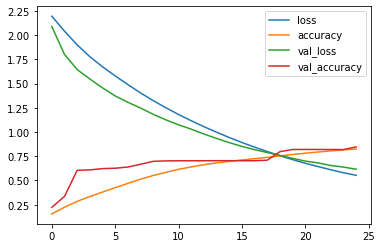

In [ ]:
history = pd.DataFrame(model.history.history)
history.plot()

## Precision

In [ ]:
print("Classification accuracy:")
classification_dict = dict()
accuracy_list = list() 

for key in x_test_dict:
    x_test_numpy = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1).values
    x_test_numpy = x_test_numpy.reshape(x_test_numpy.shape[0],x_test_numpy.shape[1], 1)
    classify = model.predict(x_test_numpy)
    classifications = [i.argmax() for i in classify]
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
    print(f"{key}: {accuracy_list[-1]}%")
    classification_dict[key] = classifications

print(f"Average accuracy: {round(sum(accuracy_list)/len(accuracy_list),2)}%")

Classification accuracy:
001: 72.34%
002: 90.07%
004: 84.67%
005: 88.79%
006: 87.79%
007: 65.32%
009: 85.58%
010: 44.83%
Average accuracy: 77.42%


## Visualise classification

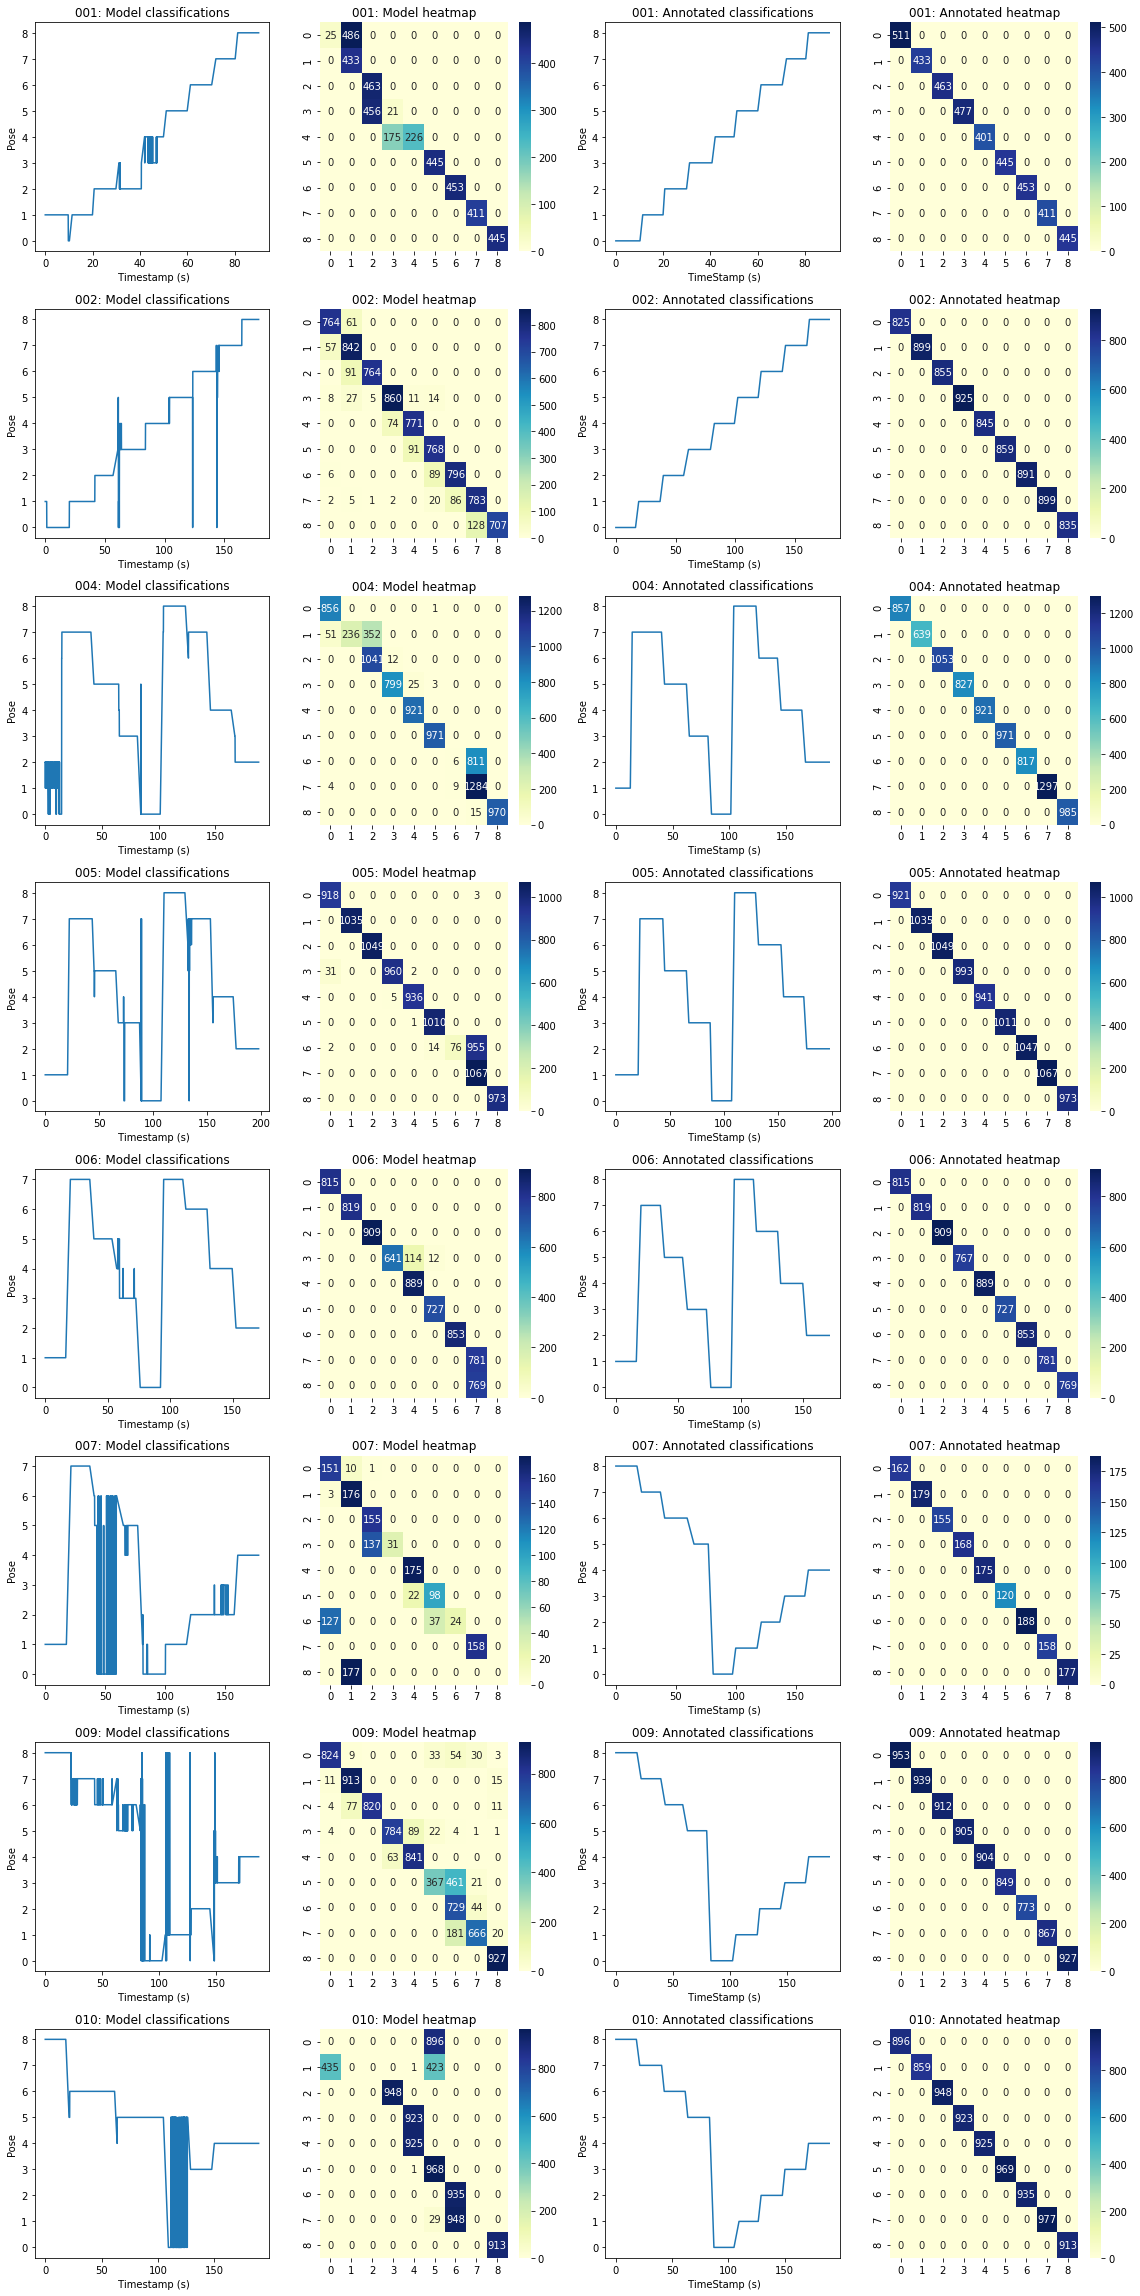

In [ ]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()

In [ ]:
"""
path = f"../models/CNN_model_{AMOUNT_OF_SENSORS}.h5"
model.save(path)
"""


'\npath = f"../models/CNN_model_{AMOUNT_OF_SENSORS}.h5"\nmodel.save(path)\n'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>